Bounding box example

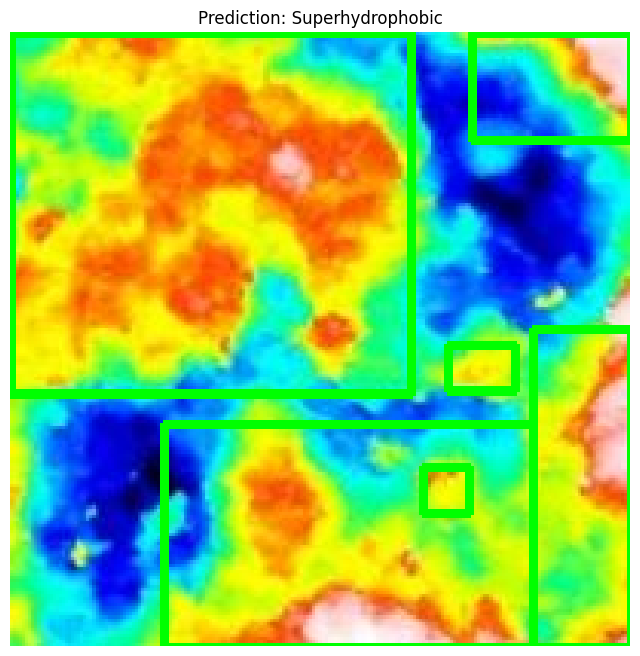

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_path = '/content/1.JPG'
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

red_lower1 = np.array([0, 120, 120])
red_upper1 = np.array([10, 255, 255])
red_lower2 = np.array([160, 120, 120])
red_upper2 = np.array([179, 255, 255])

yellow_lower = np.array([20, 120, 120])
yellow_upper = np.array([35, 255, 255])

red_mask1 = cv2.inRange(hsv, red_lower1, red_upper1)
red_mask2 = cv2.inRange(hsv, red_lower2, red_upper2)
red_mask = cv2.bitwise_or(red_mask1, red_mask2)
yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)

combined_mask = cv2.bitwise_or(red_mask, yellow_mask)

contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
output_img = image.copy()

for contour in contours:
    if cv2.contourArea(contour) > 100:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(output_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

red_area = cv2.countNonZero(red_mask)
total_area = image.shape[0] * image.shape[1]
red_ratio = red_area / total_area

prediction = "Hydrophobic" if red_ratio > 0.05 else "Superhydrophobic"

output_img_rgb = cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8, 8))
plt.imshow(output_img_rgb)
plt.title(f"Prediction: {prediction}")
plt.axis('off')
plt.show()



Simple CNN model - not that great accuracy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/MyDrive/Dataset divide'

In [ ]:
def load_images_from_drive(dataset_path, image_size=(128, 128)):
    images = []
    labels = []
    label_map = {"Hydrophobic": 0, "Superhydrophobic": 1}

    for label_folder, label in label_map.items():
        folder_path = os.path.join(dataset_path, label_folder)

        for sample_folder in os.listdir(folder_path):
            sample_path = os.path.join(folder_path, sample_folder)

            for img_name in os.listdir(sample_path):
                img_path = os.path.join(sample_path, img_name)
                image = cv2.imread(img_path)

                if image is None:
                    continue
                image_resized = cv2.resize(image, image_size)
                red_area, _ = extract_red_region(image_resized)
                red_area_ratio = normalize_feature(red_area, image_size[0] * image_size[1])

                images.append(image_resized)
                labels.append(label)

    return np.array(images), np.array(labels)

In [ ]:
def build_cnn_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
def extract_red_region(image):
    if image is None:
        return 0, (0, 0, 0, 0)

    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lower_red1 = np.array([0, 120, 70])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 120, 70])
    upper_red2 = np.array([180, 255, 255])


    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    mask = cv2.bitwise_or(mask1, mask2)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(largest)
        x, y, w, h = cv2.boundingRect(largest)
        return area, (x, y, w, h)
    else:
        return 0, (0, 0, 0, 0)

def normalize_feature(red_area, image_area):
    return red_area / image_area if image_area > 0 else 0

In [ ]:
def preprocess_and_train_model(dataset_path):
    images, labels = load_images_from_drive(dataset_path)
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
    model = build_cnn_model((128, 128, 3))
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

    return model

In [ ]:
dataset_path = '/content/drive/MyDrive/Dataset divide'

model = preprocess_and_train_model(dataset_path)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5439 - loss: 782.3827 - val_accuracy: 0.5500 - val_loss: 19.9946
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 732ms/step - accuracy: 0.5629 - loss: 14.0524 - val_accuracy: 0.3833 - val_loss: 2.1860
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 713ms/step - accuracy: 0.5285 - loss: 1.4838 - val_accuracy: 0.4833 - val_loss: 0.9800
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 853ms/step - accuracy: 0.7143 - loss: 0.5726 - val_accuracy: 0.4500 - val_loss: 0.8929
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 668ms/step - accuracy: 0.8738 - loss: 0.3501 - val_accuracy: 0.6000 - val_loss: 0.9113
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 989ms/step - accuracy: 0.9330 - loss: 0.2214 - val_accuracy: 0.5833 - val_loss: 0.9649
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 724ms/step - accuracy: 0.9744 - loss: 0.1315 - val_accuracy: 0.5333 - val_loss: 1.3381
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 699ms/step - accuracy: 0.9854 - loss: 0.0839 - val_accuracy: 0.5167 - val_loss: 1.1342

New implementation - better performance

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_images_from_drive(dataset_path):
    import os
    import cv2
    import numpy as np

    categories = ['Hydrophobic', 'Superhydrophobic']
    images = []
    red_areas = []
    labels = []

    for label, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)
        for sample_folder in os.listdir(category_path):
            sample_path = os.path.join(category_path, sample_folder)
            if not os.path.isdir(sample_path):
                continue
            for filename in os.listdir(sample_path):
                file_path = os.path.join(sample_path, filename)
                image = cv2.imread(file_path)
                if image is None:
                    continue
                image = cv2.resize(image, (128, 128))

                red_area, _ = extract_red_region(image)

                red_area_norm = red_area / (128 * 128)

                images.append(image)
                red_areas.append([red_area_norm])
                labels.append(label)

    return np.array(images), np.array(red_areas), np.array(labels)

In [ ]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Concatenate, Dropout
from tensorflow.keras.models import Model

def build_hybrid_model(image_shape):
    image_input = Input(shape=image_shape, name="image_input")
    x = Conv2D(32, (3,3), activation='relu')(image_input)
    x = MaxPooling2D()(x)
    x = Conv2D(64, (3,3), activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    red_area_input = Input(shape=(1,), name="red_area_input")
    y = Dense(16, activation='relu')(red_area_input)
    combined = Concatenate()([x, y])
    z = Dense(64, activation='relu')(combined)
    z = Dropout(0.5)(z)
    output = Dense(2, activation='softmax')(z)
    model = Model(inputs=[image_input, red_area_input], outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
def extract_red_region(image):
    if image is None:
        return 0, (0, 0, 0, 0)

    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_red1 = np.array([0, 120, 70])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 120, 70])
    upper_red2 = np.array([180, 255, 255])
    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    mask = cv2.bitwise_or(mask1, mask2)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(largest)
        x, y, w, h = cv2.boundingRect(largest)
        return area, (x, y, w, h)
    else:
        return 0, (0, 0, 0, 0)

def normalize_feature(red_area, image_area):
    return red_area / image_area if image_area > 0 else 0

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

def preprocess_and_train_model(dataset_path):
    images, red_areas, labels = load_images_from_drive(dataset_path)
    images, red_areas, labels = load_images_from_drive(dataset_path)
    X_train, X_test, red_areas_train, red_areas_test, y_train, y_test = train_test_split(
        images, red_areas, labels, test_size=0.2, random_state=42)
    model = build_hybrid_model((128, 128, 3))
    datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2
    )
    datagen.fit(X_train)
    early_stop = EarlyStopping(patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-6)
    history = model.fit(
        {'image_input': X_train, 'red_area_input': red_areas_train},
        y_train,
        validation_data=(
            {'image_input': X_test, 'red_area_input': red_areas_test},
            y_test
        ),
        epochs=30,
        callbacks=[early_stop, reduce_lr]
    )
    for epoch in range(len(history.history['accuracy'])):
      train_acc = history.history['accuracy'][epoch]
      val_acc = history.history['val_accuracy'][epoch]
      print(f"Epoch {epoch+1}: Train Accuracy = {train_acc:.4f}, Validation Accuracy = {val_acc:.4f}")

    return model

In [ ]:
dataset_path = '/content/drive/MyDrive/Dataset divide'

model = preprocess_and_train_model(dataset_path)

Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5176 - loss: 576.0433 - val_accuracy: 0.5500 - val_loss: 17.1098 - learning_rate: 0.0010
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 725ms/step - accuracy: 0.5800 - loss: 17.4026 - val_accuracy: 0.5500 - val_loss: 2.0740 - learning_rate: 0.0010
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 879ms/step - accuracy: 0.5455 - loss: 1.4151 - val_accuracy: 0.5500 - val_loss: 3.7349 - learning_rate: 0.0010
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 841ms/step - accuracy: 0.5500 - loss: 3.5318 - val_accuracy: 0.5500 - val_loss: 0.7146 - learning_rate: 0.0010
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 692ms/step - accuracy: 0.6355 - loss: 0.6954 - val_accuracy: 0.5500 - val_loss: 0.7142 - learning_rate: 0.0010
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 991ms/step - accuracy: 0.6186 - loss: 0.6923 - val_accuracy: 0.5500 - val_loss: 0.7029 - learning_rate: 0.0010
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 702ms/step - accuracy: 0.6424 - loss: 0.6714 - val_accurac

Loading the csv

In [ ]:
data = pd.read_csv('/content/Major Project(Etchants).csv')

In [ ]:
def recommend_from_csv(classification):
    filtered_data = data[data['Label'] == classification]
    filtered_data['distance'] = filtered_data.apply(lambda row: calculate_distance(row), axis=1)
    best_match = filtered_data.loc[filtered_data['distance'].idxmin()]

    contact_angle = best_match['Contact Angle']
    etchants = {
        "FeCl3": best_match['FeCl3'],
        "Hcl": best_match['Hcl'],
        "Stearic Acid": best_match['Stearic Acid']
    }
    time = best_match['Time(in seconds)']

    return contact_angle, etchants, time

In [ ]:
def calculate_distance(row, classification, red_area_ratio=None):
    contact_angle_diff = abs(row['Contact Angle'] - 150)
    etchant_diff = abs(row['FeCl3'] - 2) + abs(row['Hcl'] - 1) + abs(row['Stearic Acid'] - 1)
    total_diff = contact_angle_diff + etchant_diff
    return total_diff

In [ ]:
def recommend_from_csv(classification):
    filtered_data = data[data['Label'] == classification]
    filtered_data['distance'] = filtered_data.apply(lambda row: calculate_distance(row, classification), axis=1)
    best_match = filtered_data.loc[filtered_data['distance'].idxmin()]
    contact_angle = best_match['Contact Angle']
    etchants = {
        "FeCl3": best_match['FeCl3'],
        "Hcl": best_match['Hcl'],
        "Stearic Acid": best_match['Stearic Acid']
    }
    time = best_match['Time(in seconds)']

    return contact_angle, etchants, time

In [ ]:
new_image_path = '/content/Capture.JPG'
classification_label, contact_angle, etchants, time = classify_and_predict(new_image_path, model)
print(f"Predicted Class: {classification_label}")
print(f"Recommended Contact Angle: {contact_angle}°")
print(f"Recommended Etchants: FeCl3={etchants['FeCl3']}, Hcl={etchants['Hcl']}, Stearic Acid={etchants['Stearic Acid']}")
print(f"Recommended Time: {time} seconds")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicted Class: Hydrophobic
Recommended Contact Angle: 138.0°
Recommended Etchants: FeCl3=0.0, Hcl=1.0, Stearic Acid=1.0
Recommended Time: 40.0 seconds


<ipython-input-78-53c85b95b4cd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['distance'] = filtered_data.apply(lambda row: calculate_distance(row, classification), axis=1)
